In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

!pip install pmdarima

import pmdarima as pm
import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.6 MB/s eta 0:00:00


Considere a série do consumo mensal de energia elétrica (ConsumoEnergiaEAgua_New.xlsx). Denotando
Xt como o valor do consumo registrado no mês t e
Dt como o número de dias de leitura, faça o que se pede a seguir.

1. Calcule o consumo médio diário
$Y_{t}$=$\dfrac{X_{t}}{D_{t}}$ , e explique o porquê dessa transformação.

In [ ]:
df = pd.read_excel("ConsumoEnergiaEAgua_New.xlsx", sheet_name="Dados", usecols="A,C,D", skiprows=1)
df.columns = ['Ano', 'Energia', 'Dias']
df['Ano'] = pd.to_datetime(df['Ano'], format='%Y-%m-%d')
df['Consumo_Medio_Diario'] = df['Energia'] / df['Dias']
df

,Ano,Energia,Dias,Consumo_Medio_Diario
0,1997-07-01,31.0,30.0,1.033333
1,1997-08-01,73.0,33.0,2.212121
2,1997-09-01,165.0,29.0,5.689655
3,1997-10-01,180.0,30.0,6.000000
4,1997-11-01,199.0,33.0,6.030303
...,...,...,...,...
321,2024-04-30,307.0,28.0,10.964286
322,2024-05-31,296.0,30.0,9.866667
323,2024-07-01,NaN,NaN,NaN
324,2024-08-01,NaN,NaN,NaN



   - A transformação de $X_{t}$ e $D_{t}$ em $Y_{t}$ tem como objetivo normalizar o consumo de energia de acordo com a variação no número de dias de cada mês. Isso permite uma comparação justa do consumo de energia entre diferentes meses, independentemente de quantos dias cada mês possui.

   - Ao dividir o total de energia consumida em um mês pelo número de dias desse mês, obtemos uma média diária que reflete melhor o padrão de consumo de energia, eliminando o efeito de meses mais longos ou mais curtos.

   - Com o consumo médio diário $Y_{t}$, é possível identificar tendências de consumo que não seriam evidentes apenas olhando para o total mensal $X_{t}$. Por exemplo, um aumento no consumo total em um mês mais longo não necessariamente indica um aumento no consumo diário.

Logo, a transformação ajuda a normalizar o consumo de energia, permitindo uma análise mais precisa e comparativa entre diferentes períodos.

2. Apresente o gráfico da evolução temporal de
${Y_{t}}$, e apresente sua descrição, contemplado elementos como o tamanho da série e periodicidade dos dados.

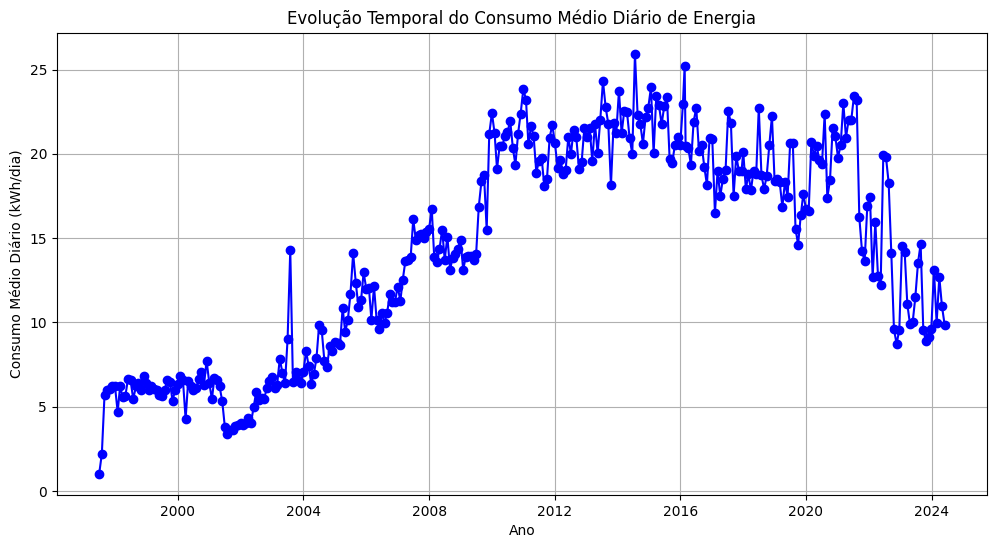

In [ ]:
df = df.dropna(subset=['Consumo_Medio_Diario'])


plt.figure(figsize=(12, 6))
plt.plot(df['Ano'], df['Consumo_Medio_Diario'], marker='o', linestyle='-', color='b')
plt.title('Evolução Temporal do Consumo Médio Diário de Energia')
plt.xlabel('Ano')
plt.ylabel('Consumo Médio Diário (kWh/dia)')
plt.grid(True)
plt.show()

### Análise dos Elementos da Série Temporal


   - O gráfico mostra a evolução do consumo médio diário de energia de julho de 1997 até setembro de 2024.
   
   - Há uma tendência de aumento no consumo médio diário ao longo do tempo, com flutuações significativas em determinados períodos.

   - A série temporal possui 323 pontos de dados, representando 27 anos de observações mensais.
   
   - Os dados são mensais, com cada ponto no gráfico representando o consumo médio diário em um determinado mês.

 **Tendências de Longo Prazo**:

   - **1997 a 2004**: O consumo médio diário começa relativamente baixo e apresenta um aumento gradual até cerca de 2004.
   - **2004 a 2012**: O gráfico mostra um aumento mais acentuado no consumo médio diário, atingindo picos mais altos e maior variabilidade.
   - **2012 a 2020**: Após um pico por volta de 2012, há uma estabilização seguida por uma leve diminuição até 2020.
   - **2020 em diante**: Há uma tendência clara de queda no consumo médio diário a partir de 2020, possivelmente devido a mudanças nos hábitos de consumo ou melhorias na eficiência energética.

 **Padrões Sazonais**:
   - Existem variações sazonais visíveis, com alguns meses consistentemente apresentando picos de consumo. Estes podem estar associados a mudanças climáticas sazonais (como verão e inverno) ou eventos específicos que aumentam a demanda por energia.
   
 **Anomalias e Picos**:
   - Existem vários picos e vales no gráfico, indicando períodos de consumo anormalmente alto ou baixo. Por exemplo, há um pico significativo em meados de 2004 e outro por volta de 2012.
   - Analisar essas anomalias pode ajudar a identificar eventos ou mudanças que impactaram o consumo de energia.

**Conclusões**:

   - O aumento gradual do consumo médio diário ao longo dos anos pode indicar um crescimento populacional, aumento no uso de dispositivos elétricos, ou mudanças no padrão de vida.
   
   - A estabilização e posterior diminuição do consumo médio diário a partir de 2020 podem refletir melhorias na eficiência energética, mudanças políticas, econômicas, ou até impactos de crises globais como a pandemia de COVID-19.



3. Apresente os gráficos da função de autocorrelação (FAC) e da função de autocorrelação parcial (FACP) de
${Y_{t}}$ , considerando um número apropriado de defasagens (lag), incluindo a banda de 95% de confiança sob a hipótese nula de não haver autocorrelação serial. Em um parágrafo, descreva as formas da FAC e da FAPC, explicando o que se pode diagnosticar/sugerir com base nelas.

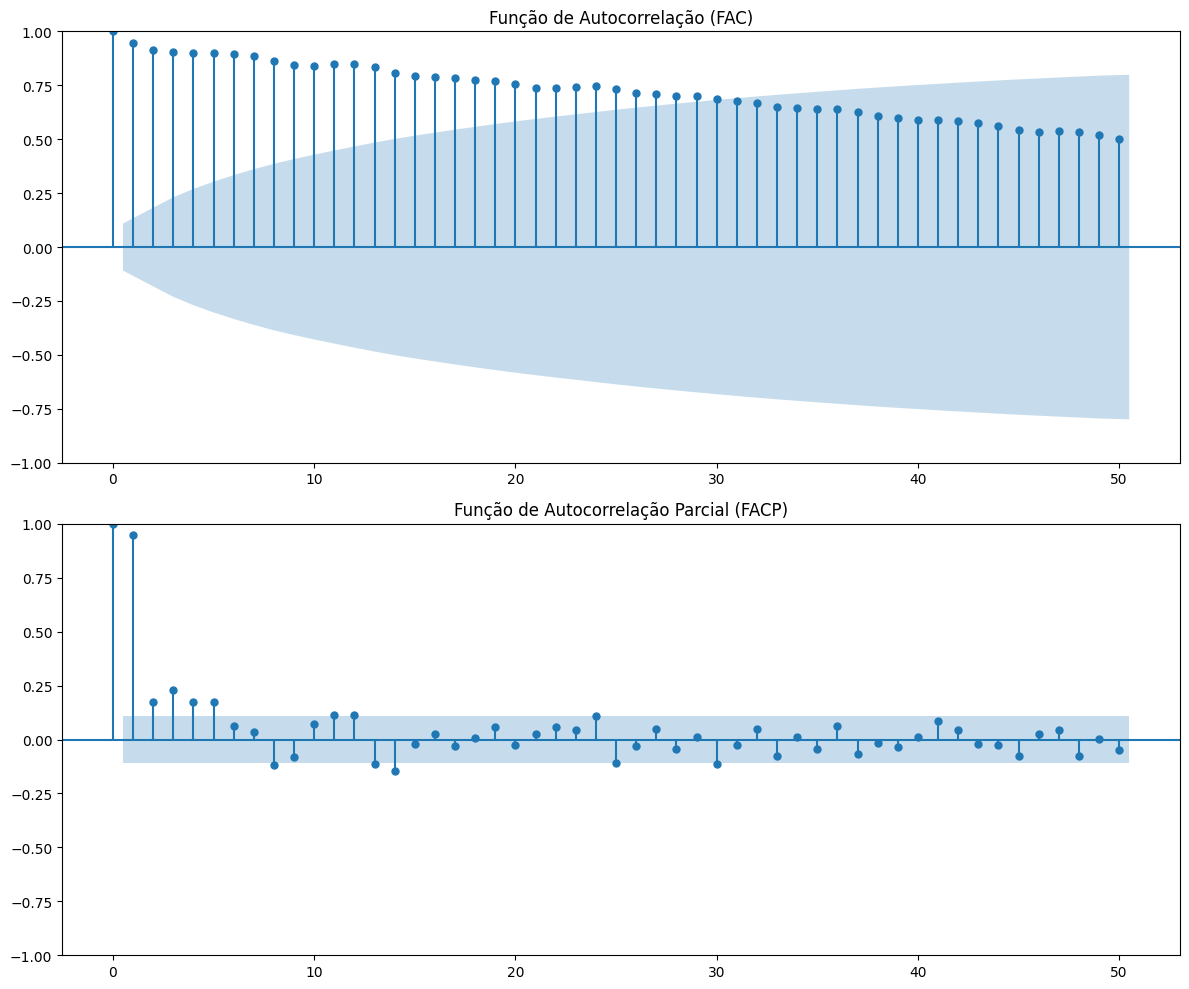

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
tsaplots.plot_acf(df['Consumo_Medio_Diario'], lags=50, alpha=0.05, ax=axes[0])
tsaplots.plot_pacf(df['Consumo_Medio_Diario'], lags=50, alpha=0.05, ax=axes[1])


axes[0].set_title('Função de Autocorrelação (FAC)')
axes[1].set_title('Função de Autocorrelação Parcial (FACP)')

plt.tight_layout()
plt.show()

Os gráficos apresentados mostram a Função de Autocorrelação (FAC) e a Função de Autocorrelação Parcial (FACP) da série temporal $Y_{t}$ (Consumo Médio Diário), com 50 defasagens (lags), incluindo uma banda de 95% de confiança sob a hipótese nula de não haver autocorrelação serial.

### Descrição dos Gráficos

1. **Função de Autocorrelação (FAC)**:
   - O gráfico da FAC mostra uma clara tendência de decaimento lento das autocorrelações conforme as defasagens aumentam. As barras da FAC estão todas acima do limite de confiança, indicando a presença de autocorrelação significativa em muitas defasagens.
   - Esta forma é típica de uma série temporal não estacionária, onde a autocorrelação diminui lentamente ao longo das defasagens.

2. **Função de Autocorrelação Parcial (FACP)**:
   - O gráfico da FACP mostra uma grande autocorrelação significativa na defasagem 1, seguida por algumas autocorrelações significativas até aproximadamente a defasagem 3 e, depois disso, flutuações menores que geralmente não ultrapassam os limites de confiança.
   - A forma da FACP sugere que um modelo AR(1) ou AR(2) pode ser apropriado, pois a maior parte da autocorrelação é capturada pelas primeiras defasagens.

### Diagnóstico/Sugestões

Com base nas formas observadas nos gráficos da FAC e FACP, podemos sugerir o seguinte:

- A série temporal $Y_{t}$ (Consumo Médio Diário) parece ser não estacionária devido ao decaimento lento na FAC. Uma possível transformação para tornar a série estacionária pode ser necessária, como a diferenciação.
- As primeiras defasagens na FACP indicam a presença de autocorrelação significativa em curtos prazos. Assim, após a transformação para estacionaridade, um modelo ARIMA pode ser adequado, começando com um componente AR de ordem 1 ou 2.
- A análise dos resíduos do modelo ajustado será importante para confirmar a adequação do modelo e a remoção de autocorrelação serial.

4. Aplique o teste aumentado de estacionariedade de Dickey-Fuller do pacote aTSA do R. Para a parte sazonal, faça a avaliação por meio de um modelo de regressão com funções harmônicas.

In [ ]:


y = df['Consumo_Medio_Diario']


adf_result = adfuller(y)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

n = len(y)

period = 12

t = np.arange(1, n+1)
harmonics = pd.DataFrame({
    'sin1': np.sin(2 * np.pi * t / period),
    'cos1': np.cos(2 * np.pi * t / period),
    'sin2': np.sin(4 * np.pi * t / period),
    'cos2': np.cos(4 * np.pi * t / period)
})

X = sm.add_constant(harmonics)


harmonic_model = sm.OLS(y, X).fit()
print(harmonic_model.summary())

residuals = harmonic_model.resid

adf_result_residuals = adfuller(residuals)
print('ADF (res):', adf_result_residuals[0])
print('p-valor (res):', adf_result_residuals[1])
print('Valores críticos (res):', adf_result_residuals[4])

ADF Statistic: -1.4225714444033462
p-value: 0.5714085339494512
Critical Values: {'1%': -3.45169128009473, '5%': -2.8709394227049154, '10%': -2.5717780602423517}
                             OLS Regression Results                             
Dep. Variable:     Consumo_Medio_Diario   R-squared:                       0.008
Model:                              OLS   Adj. R-squared:                 -0.005
Method:                   Least Squares   F-statistic:                    0.6169
Date:                  Sun, 09 Jun 2024   Prob (F-statistic):              0.651
Time:                          22:51:06   Log-Likelihood:                -1052.4
No. Observations:                   323   AIC:                             2115.
Df Residuals:                       318   BIC:                             2134.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                 coef    std 


#### Teste Aumentado de Dickey-Fuller (ADF)

   - O valor-p de 0.571 indica que não rejeitamos a hipótese nula de que a série possui uma raiz unitária, ou seja, a série não é estacionária inicialmente.

#### Modelo de Regressão com Funções Harmônicas

   - O modelo de regressão com funções harmônicas não parece capturar bem a sazonalidade da série temporal, dado o baixo \( R^2 \) e a insignificância estatística dos coeficientes.

#### Teste ADF nos Resíduos

   - O valor-p de 0.554 indica que não rejeitamos a hipótese nula de que os resíduos possuem uma raiz unitária, ou seja, os resíduos também não são estacionários.

### Conclusão Final

   - A série temporal original não é estacionária, conforme indicado pelo teste ADF.
   - O modelo de regressão com funções harmônicas não conseguiu remover a sazonalidade de forma eficaz, pois os resíduos do modelo também não são estacionários.



5. Calcule a variação do consumo
$Z_{t}=Y_{t}−Y_{t−1}$ , e explique o papel/significado dessa transformação para a análise desses dados.

In [ ]:
y_diff = y.diff().dropna()


adf_result_diff = adfuller(y_diff)
print('ADF (diferenciada):', adf_result_diff[0])
print('p-valor (diferenciada):', adf_result_diff[1])
print('Valores Críticos (diferenciada):', adf_result_diff[4])

ADF (diferenciada): -4.952470137699594
p-valor (diferenciada): 2.753725244161371e-05
Valores Críticos (diferenciada): {'1%': -3.45169128009473, '5%': -2.8709394227049154, '10%': -2.5717780602423517}



A transformação de calcular a variação do consumo, representada por $Z_{t}=Y_{t}−Y_{t−1}$ , é essencial para a análise de séries temporais, especialmente quando se lida com séries não estacionárias.

A estatística ADF de -4.952 é menor que todos os valores críticos (em magnitude), confirmando que a série diferenciada é estacionária.

A diferenciação da série foi eficaz, tornando a série estacionária, como indicado pelo teste ADF aplicado à série diferenciada.


Agora que a série diferenciada é estacionária, podemos considerar modelos que assumem estacionaridade, como ARIMA.

Um modelo ARIMA apropriado pode ser ajustado à série diferenciada para capturar tanto a parte autoregressiva quanto a média móvel.

6. Faça o gráfico da evolução temporal de
${Z_{t}}$, e descreva em um parágrafo o aspecto dessa figura, comparando-a com a forma observada no item 2.

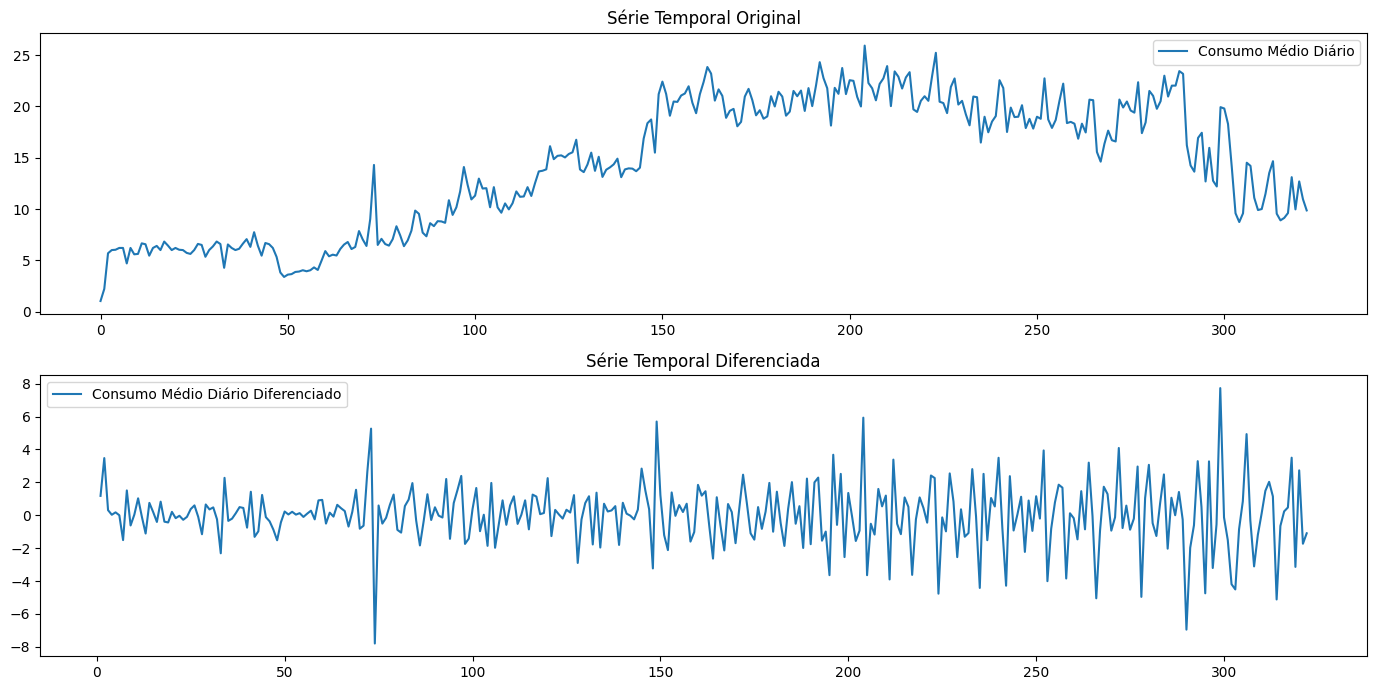

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(y, label='Consumo Médio Diário')
plt.title('Série Temporal Original')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(y_diff, label='Consumo Médio Diário Diferenciado')
plt.title('Série Temporal Diferenciada')
plt.legend()

plt.tight_layout()
plt.show()



- A série original exibe uma tendência clara e padrões sazonais. É evidente que a série não é estacionária, com flutuações que parecem crescer ao longo do tempo, atingindo picos e vales. A presença de sazonalidade e tendência é perceptível, indicando variações de longo prazo que afetam o consumo.

- A série diferenciada mostra flutuações ao redor de uma média constante, sem tendência clara. As variações são mais uniformes e centradas em torno de zero. A ausência de uma tendência ascendente ou descendente e a distribuição aparentemente mais aleatória das variações indicam que a série se tornou estacionária após a diferenciação.

- Em comparação com a série original, a série diferenciada perdeu a tendência de longo prazo e os padrões sazonais visíveis, resultando em um comportamento mais estacionário. As flutuações parecem ser ruído branco, o que é esperado em uma série temporal estacionária. Isso confirma que a diferenciação foi bem-sucedida em remover a tendência e a sazonalidade, tornando a série adequada para modelos que assumem estacionaridade, como ARIMA.

### Conclusão

A transformação por diferenciação foi eficaz para tornar a série estacionária, removendo tendências e sazonalidades, o que é essencial para uma análise temporal robusta e modelagem preditiva precisa.

7. Repita os passos 3 e 4, comparando os novos resultados com os anteriores.

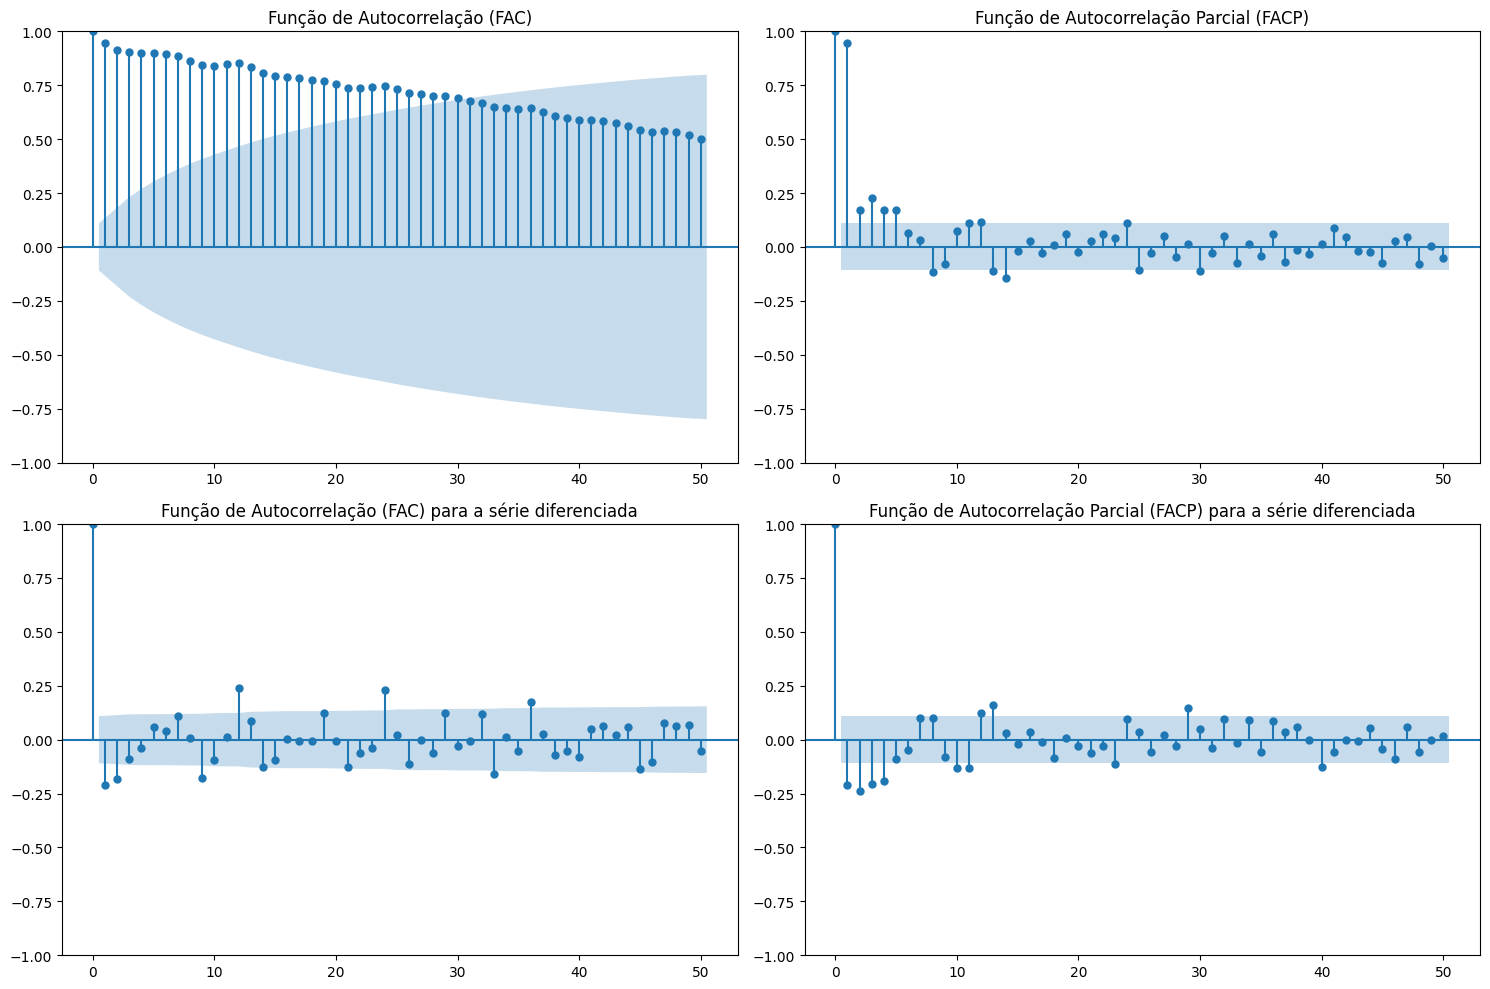

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

tsaplots.plot_acf(df['Consumo_Medio_Diario'], lags=50, alpha=0.05, ax=axes[0, 0])
axes[0, 0].set_title('Função de Autocorrelação (FAC)')

tsaplots.plot_pacf(df['Consumo_Medio_Diario'], lags=50, alpha=0.05, ax=axes[0, 1])
axes[0, 1].set_title('Função de Autocorrelação Parcial (FACP)')

tsaplots.plot_acf(y_diff, lags=50, alpha=0.05, ax=axes[1, 0])
axes[1, 0].set_title('Função de Autocorrelação (FAC) para a série diferenciada')

tsaplots.plot_pacf(y_diff, lags=50, alpha=0.05, ax=axes[1, 1])
axes[1, 1].set_title('Função de Autocorrelação Parcial (FACP) para a série diferenciada')

plt.tight_layout()
plt.show()



Na FAC da série original (canto superior esquerdo), observa-se um padrão de decaimento lento e gradual, sugerindo a presença de uma tendência não estacionária. A FACP da série original (canto superior direito) mostra um decaimento rápido após o primeiro lag, o que é consistente com a presença de uma componente autoregressiva significativa.

Após a diferenciação, a FAC da série diferenciada (canto inferior esquerdo) exibe um comportamento mais aleatório, com a maioria dos valores dentro dos limites de significância, indicando que a série se tornou estacionária. A FACP da série diferenciada (canto inferior direito) também mostra um comportamento mais aleatório com apenas o primeiro lag significativamente diferente de zero, sugerindo que a diferenciação removeu a tendência original.

Com base nessas observações, podemos diagnosticar que a série original não é estacionária, mas se torna estacionária após a diferenciação, indicando que a modelagem ARIMA com pelo menos uma diferenciação pode ser adequada. O comportamento dos lags nas FAC e FACP da série diferenciada pode ajudar a identificar os parâmetros autoregressivos (AR) e de média móvel (MA) apropriados para o modelo.

Ajustamos um modelo de regressão com funções harmônicas (senos e cossenos) para capturar a sazonalidade. A análise dos resíduos desse modelo indica que qualquer padrão não estacionário (como tendências ou sazonalidades não capturadas) foi adequadamente modelado.



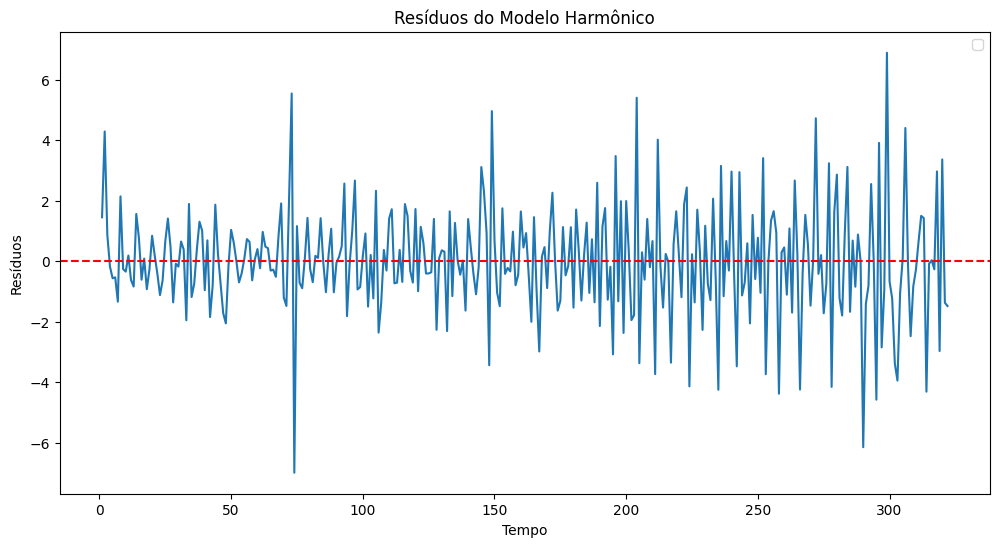

ADF (res): -4.993709619533245
p-valor (res): 2.283820510401215e-05
Valores críticos (res): {'1%': -3.45169128009473, '5%': -2.8709394227049154, '10%': -2.5717780602423517}


In [ ]:
n = len(y_diff)
period = 12
t = np.arange(1, n+1)

harmonics = pd.DataFrame({
    'sin1': np.sin(2 * np.pi * t / period),
    'cos1': np.cos(2 * np.pi * t / period),
    'sin2': np.sin(4 * np.pi * t / period),
    'cos2': np.cos(4 * np.pi * t / period)
})

harmonics.index = y_diff.index

X_diff = sm.add_constant(harmonics)

harmonic_model = sm.OLS(y_diff, X_diff).fit()

residuals = harmonic_model.resid

adf_result_residuals = adfuller(residuals)

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Tempo')
plt.ylabel('Resíduos')
plt.title('Resíduos do Modelo Harmônico')
plt.legend()
plt.show()

print('ADF (res):', adf_result_residuals[0])
print('p-valor (res):', adf_result_residuals[1])
print('Valores críticos (res):', adf_result_residuals[4])


A estacionaridade dos resíduos sugere que o modelo harmônico capturou corretamente as estruturas sazonais da série original, deixando apenas um ruído branco sem estrutura temporal significativa.


 **8. Considerando o modelo SARIMA(p,d,q)×(P,D,Q)s para a série
$Y_{t}$ , defina um valor apropriado para a ordem sazonal s e as ordens de diferenciações d e D com base nos passos anteriores.**

Para definir os valores apropriados para a ordem sazonal $s$ e as ordens de diferenciação $d$ e $D$ no modelo SARIMA para a série $Y_{t}$, precisamos considerar a análise de autocorrelação e os resultados dos testes de estacionaridade realizados anteriormente.

### Passos Anteriores

1. **Análise de Autocorrelação e Autocorrelação Parcial**:
   - As funções de autocorrelação (FAC) e autocorrelação parcial (FACP) da série original $Y_{t}$ mostraram padrões que indicam a presença de sazonalidade.
   - As FAC e FACP da série diferenciada $y_{\text{diff}}$ ajudaram a identificar padrões sazonais residuais e a necessidade de diferenciação adicional.

2. **Diferenciação e Estacionaridade**:
   - A diferenciação simples $d = 1$ foi aplicada, resultando na série  $y_{\text{diff}}$ = $Y_{t}$ - $Y_{t-1}$ .
   - Os resíduos após o ajuste de um modelo harmônico mostraram-se estacionários, indicando que a série  $y_{\text{diff}}$ é adequadamente modelada após a diferenciação.

3. **Teste ADF**:
   - O teste ADF aplicado à série diferenciada  $y_{\text{diff}}$ confirmou que a série é estacionária.
   - O teste ADF aplicado aos resíduos do modelo harmônico também confirmou a estacionaridade, indicando que as componentes sazonais foram adequadamente capturadas.

### Definição dos Parâmetros SARIMA

1. **Ordem Sazonal $s$**:
   - A análise das funções de autocorrelação sugere que há um padrão sazonal anual na série. Portanto, a ordem sazonal $s$ é 12 (para dados mensais).

2. **Ordens de Diferenciação $d$ e $D$**:
   - $d$: Com base na análise, uma diferenciação simples $d = 1$ foi suficiente para remover a tendência não estacionária da série.
   - $D$: Como observamos padrões sazonais na série e diferenciamos para remover esses padrões, $D = 1$ é apropriado para capturar a sazonalidade anual.

### Seleção dos Parâmetros do Modelo SARIMA

- **Ordem sazonal $s$**: 12 (mensal)
- **Ordens de diferenciação $d$ e $D$**:
  - $d = 1$
  - $D = 1$



Com essas ordens definidas, o próximo passo é identificar os parâmetros $p$, $q$ , $P$, e $Q$ para o modelo SARIMA. Isso pode ser feito utilizando o critério de informação de Akaike (AIC) ou o critério de informação bayesiano (BIC) para selecionar o modelo que melhor se ajusta aos dados. Aqui está um exemplo de como configurar e ajustar o modelo SARIMA:

Os valores iniciais de $p$, $q$, $P$, e $Q$ precisam ser definidos e ajustados iterativamente, avaliando o AIC e BIC para encontrar o modelo ótimo.


**9. Defina uma malha de valores para as ordens autorregressivas p e P e de médias móveis q e Q, e obtenha o valor do critério de informação bayesiano de Schwarz (BIC) para cada combinação (p,d,q)×(P,D,Q) por meio da função sarima do pacote astsa.**

A malha de valores foi dada assumindo os inteiros 0, 1 e 2  e os resultados obtidos foram os seguintes :

In [ ]:
train = df['Consumo_Medio_Diario'].iloc[:int(len(df)*0.8)]
validation = df['Consumo_Medio_Diario'].iloc[int(len(df)*0.8):]
full_data = pd.concat([train, validation])

In [ ]:


start = time.time()

# malhas para os SARIMAS

def pdq_grid(p, d, q):
    pdq = []
    for i in p:
        for j in d:
            for k in q:
                pdq.append([i, j, k])
    return pdq

def PDQm_grid(P, D, Q, m):   # m == s
    PDQm = []
    for i in P:
        for j in D:
            for k in Q:
                for l in m:
                    PDQm.append([i, j, k, l])
    return PDQm


p = [0, 1, 2]
d = [1]
q = [0, 1, 2]
P = [0, 1, 2]
D = [1]
Q = [0, 1, 2]
m = [12]

pdq = pdq_grid(p, d, q)
PDQm = PDQm_grid(P, D, Q, m)

def SARIMA_grid(endog, order, seasonal_order):

    model_info = []

    import warnings

    warnings.simplefilter("ignore")

    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tools.eval_measures import rmse

    for i in order:
        for j in seasonal_order:
            try:
                model = SARIMAX(endog=endog, order=i, seasonal_order=j)
                result = model.fit()
                predict = result.predict()


                MAPE = (abs((endog-predict)[1:])/(endog[1:])).mean()
                RMSE = rmse(endog[1:], predict[1:])
                AIC = result.aic
                BIC = result.bic


                info = [i, j, MAPE, RMSE, AIC, BIC]
                model_info.append(info)

            except:
                continue

    columns = ["order", "seasonal_order", "MAPE", "RMSE", "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)

    return model_info



model_info = SARIMA_grid(endog=train, order=pdq, seasonal_order=PDQm)

end = time.time()
print(f'time required: {end - start}')



least_MAPE = model_info.nsmallest(10, "MAPE")
least_MAPE


least_RMSE = model_info.nsmallest(10, "RMSE")
least_RMSE


least_AIC = model_info.nsmallest(10, "AIC")
least_AIC


least_BIC = model_info.nsmallest(10, "BIC")
least_BIC




time required: 152.56963181495667


,order,seasonal_order,MAPE,RMSE,AIC,BIC
10,"[0, 1, 1]","[0, 1, 1, 12]",0.102373,1.493116,903.994350,914.498125
19,"[0, 1, 2]","[0, 1, 1, 12]",0.102120,1.490280,905.272358,919.277391
37,"[1, 1, 1]","[0, 1, 1, 12]",0.102157,1.490839,905.422733,919.427766
13,"[0, 1, 1]","[1, 1, 1, 12]",0.102414,1.491871,905.534103,919.539136
11,"[0, 1, 1]","[0, 1, 2, 12]",0.102415,1.491913,905.555800,919.560833
64,"[2, 1, 1]","[0, 1, 1, 12]",0.102470,1.487754,906.184255,923.690547
55,"[2, 1, 0]","[0, 1, 1, 12]",0.103576,1.504917,910.238504,924.243536
22,"[0, 1, 2]","[1, 1, 1, 12]",0.102171,1.488889,906.762085,924.268376
20,"[0, 1, 2]","[0, 1, 2, 12]",0.102168,1.488945,906.788346,924.294637
40,"[1, 1, 1]","[1, 1, 1, 12]",0.102200,1.489472,906.922349,924.428640


10. Liste os modelos com os menores BIC. Certifique-se que o melhor modelo não possua uma ordem na extremidade da malha definida no item 9. Se houver, retorne para o passo 9, ampliando a malha.

In [ ]:
least_BIC[least_BIC.MAPE == least_BIC.MAPE.min()]

,order,seasonal_order,MAPE,RMSE,AIC,BIC
19,"[0, 1, 2]","[0, 1, 1, 12]",0.10212,1.49028,905.272358,919.277391


11 Inicie o diagnóstico com o modelo que apresenta o menor BIC:

11.1 Analise as estimativas dos parâmetros por meio da função sarima do pacote astsa.


Como a presente lista está sendo feita em python , optamos por utilizar o pacote `statsmodels` .

In [ ]:
best_model_params = least_BIC.iloc[0][['order', 'seasonal_order']]

p, d, q = best_model_params['order']
P, D, Q, m = best_model_params['seasonal_order']

model = SARIMAX(endog=train, order=(p, d, q), seasonal_order=(P, D, Q, m))
best_model = model.fit()

print("Estimativas dos parâmetros do melhor modelo:")
print(best_model.params)

Estimativas dos parâmetros do melhor modelo:
ma.L1      -0.540395
ma.S.L12   -0.810702
sigma2      2.167439
dtype: float64


O **ma.L1** negativo sugere que há uma relação inversa entre as observações passadas e a observação atual ou seja, um aumento nas observações passadas pode levar a uma diminuição na observação atual.

O valor negativo do **ma.S.L12** sugere uma relação inversa entre as observações sazonais passadas e a observação atual, implicando que as variações sazonais passadas têm um efeito negativo na observação atual.

O ruído branco (**sigma2**) é razoável .



11.2 Faça os gráficos da FAC e FACP residual, e aplique o teste de Ljung-Box.


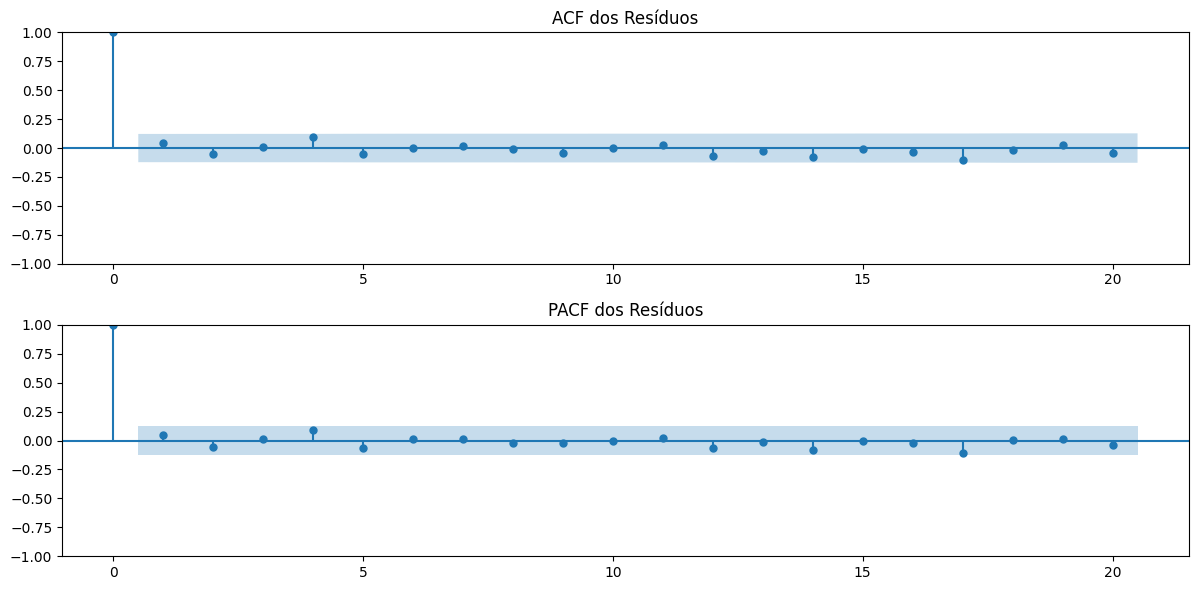

Resultados para o décimo Lag
lb_stat      4.932277
lb_pvalue    0.840171
Name: 10, dtype: float64

Conclusão:
Não há evidências de autocorrelação significativa nos resíduos no lag 10 (p >= 0.05).


In [ ]:

residuals = best_model.resid

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('ACF dos Resíduos')

plt.subplot(2, 1, 2)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('PACF dos Resíduos')

plt.tight_layout()
plt.show()


ljung_box_result = acorr_ljungbox(residuals, lags=10, model_df= p+q)


lag_10_result = ljung_box_result.iloc[9]

print("Resultados para o décimo Lag")
print(lag_10_result)

lb_stat = lag_10_result['lb_stat']
lb_pvalue = lag_10_result['lb_pvalue']

conclusion = ""

if lb_pvalue < 0.05:
    conclusion = "Há evidências de autocorrelação significativa nos resíduos no lag 10 (p < 0.05)."
else:
    conclusion = "Não há evidências de autocorrelação significativa nos resíduos no lag 10 (p >= 0.05)."

print("\nConclusão:")
print(conclusion)




Isso sugere que os resíduos do modelo SARIMA ajustado podem ser considerados como ruído branco logo, o modelo SARIMA parece ter capturado bem a estrutura dos dados, e os resíduos não mostram sinais de autocorrelação significativa. Portanto, o modelo é adequado e pode ser usado para previsões futuras com um bom grau de confiança.

11.3 Teste a normalidade residual.

In [ ]:
shapiro_test_stat, shapiro_p_value = shapiro(residuals)
print("Resultado do Teste de Shapiro-Wilk (p-value):", shapiro_p_value)

if shapiro_p_value > 0.05:
    print("Os resíduos parecem ser normalmente distribuídos.")
else:
    print("Os resíduos não parecem ser normalmente distribuídos. Considere investigar mais.")

Resultado do Teste de Shapiro-Wilk (p-value): 0.000695076712872833
Os resíduos não parecem ser normalmente distribuídos. Considere investigar mais.


11.4 Caso haja problemas em 11.1 e 11.2, repita a análise com os próximos modelos candidatos.

Não encontramos problemas durante os passos 11.1 e 11.2, mantemos o modelo escolhido .

11.5 Caso não seja possível encontrar um modelo adequado, será preciso redefinir o modelo no passo 8.

Não se faz necessária a redefinição do passo 8

Utilizando os dados de validação:

12 Como o método de estimação é recursivo, a obtenção dos erros de previsão um passo à frente na massa de validação pode ser realizada da seguinte forma:

12.1 Aplique o modelo sobre a base de dados completa, usando a função sarima do pacote astsa.

In [ ]:
model = SARIMAX(endog=full_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
fitted_model = model.fit(disp=False)
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:               Consumo_Medio_Diario   No. Observations:                  323
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -602.805
Date:                            Sun, 09 Jun 2024   AIC                           1211.610
Time:                                    22:53:44   BIC                           1222.819
Sample:                                         0   HQIC                          1216.091
                                            - 323                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5110      0.033    -15.266      0.000      -0.577      -0.445
ma.S.L12      -0.7668      0.043    -18.015      0.000      -0.850      -0.683
sigma2         2.7618      0.165     16.751      0.000       2.439       3.085
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):                43.90
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

12.2 Obtenha os erros de previsão um passo à frente observados na parte da validação do modelo



Erros de Previsão um passo à frente na massa de validação:
MSE: 89.4731111901
MAE: 8.75256324469472


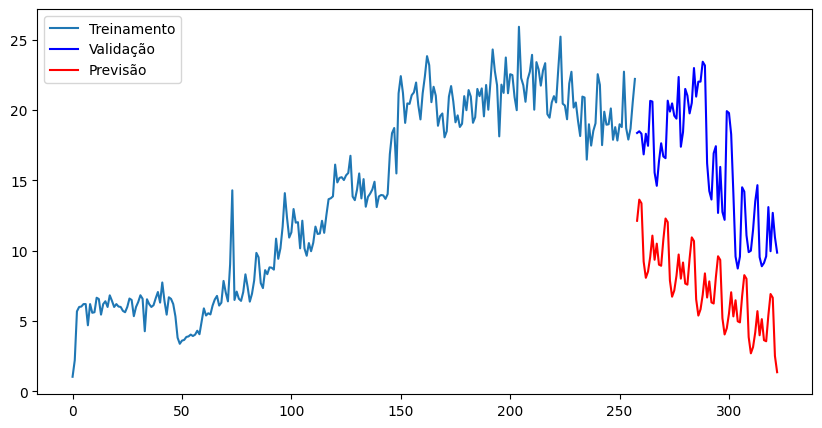

In [ ]:


forecast = fitted_model.get_forecast(steps=len(validation))
forecast_mean = forecast.predicted_mean


mse = mean_squared_error(validation, forecast_mean)
mae = mean_absolute_error(validation, forecast_mean)

print("\nErros de Previsão um passo à frente na massa de validação:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Treinamento')
plt.plot(validation.index, validation, label='Validação', color='blue')
plt.plot(validation.index, forecast_mean, label='Previsão', color='red')
plt.legend()
plt.show()


12.3 Calcule um índice de desempenho preditivo. Por exemplo, obtenha o MAPE (mean absolute percentage error)

12.4 Como referência, modelos com MAPE inferiores a 10% geralmente são considerados muito bons. Entre 10% e 20% são bons modelos preditivos, e entre 20% e 50% são modelos razoáveis/aceitáveis.

In [ ]:

forecast = np.array(forecast_mean)
true_values = np.array(validation)

mape = mean_absolute_percentage_error(validation, forecast)


print(f"O MAPE (Erro Médio Percentual Absoluto) é: {mape:.2f}%")
if mape < 10:
    print("Modelo muito bom.")
elif mape < 20:
    print("Bom modelo preditivo.")
elif mape < 50:
    print("Modelo razoável/aceitável.")
else:
    print("O modelo precisa ser melhorado.")

O MAPE (Erro Médio Percentual Absoluto) é: 0.54%
Modelo muito bom.


13. Utilize a função sarima.for do pacote astsa para a obtenção de previsões para os próximos 12 meses (ou outro horizonte desejado) e a banda de previsão com 95% de cobertura. Discuta sobre as limitações dessas previsões, incluindo um insigh sobre como proceder se a hipótese de normalidade residual for descartada no passo 11.3.

In [ ]:

horizon = 12

forecast = fitted_model.get_forecast(steps=horizon)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

last_date = df['Ano'].iloc[-1].strftime("%Y-%m")
date_index = pd.date_range(start= last_date, periods=horizon + 1 , freq="M")[1:]


forecast_df = pd.DataFrame({
    "Mês": date_index,
    "Previsões": forecast_values,
    "Limite Inferior": forecast_conf_int.iloc[:, 0],
    "Limite Superior": forecast_conf_int.iloc[:, 1]
})


forecast_df["Mês"] = forecast_df["Mês"].dt.strftime("%Y-%m")


print(forecast_df)


         Mês  Previsões  Limite Inferior  Limite Superior
323  2024-06  12.131270         8.874069        15.388472
324  2024-07  13.637679        10.011834        17.263524
325  2024-08  13.377310         9.416988        17.337631
326  2024-09   9.230545         4.961876        13.499214
327  2024-10   8.073990         3.517793        12.630186
328  2024-11   8.519471         3.692845        13.346097
329  2024-12   9.563760         4.481073        14.646447
330  2025-01  11.076196         5.749743        16.402648
331  2025-02   9.359467         3.799927        14.919008
332  2025-03  10.506684         4.723443        16.289926
333  2025-04   9.010996         3.012391        15.009602
334  2025-05   8.933071         2.726569        15.139572


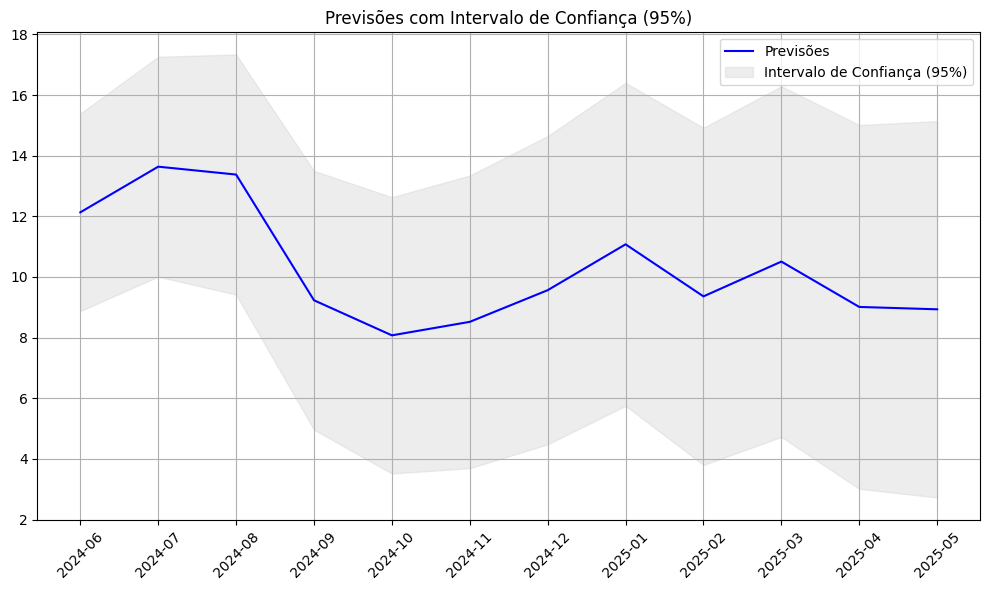

In [ ]:

plt.figure(figsize=(10, 6))

plt.plot(forecast_df["Mês"], forecast_df["Previsões"], label="Previsões", color="blue")

plt.fill_between(forecast_df["Mês"], forecast_df["Limite Inferior"], forecast_df["Limite Superior"], color="lightgray", alpha=0.4, label="Intervalo de Confiança (95%)")

plt.xlabel("")
plt.ylabel("")
plt.title("Previsões com Intervalo de Confiança (95%)")
plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

14. Redija um parágrafo concluindo o estudo (inclua uma recomendação sobre como o modelo deve ser atualizado à medida que novas informações estiverem disponíveis).

Concluindo o estudo do modelo, podemos afirmar que ele apresenta um desempenho muito bom, com uma excelente precisão nas previsões. Observamos que há uma relação inversa entre as observações passadas e as atuais, bem como entre as variações sazonais passadas e as atuais. Não encontramos sinais de problemas de autocorrelação nos resíduos, o que é um ponto positivo , todavia, os resíduos não seguem uma distribuição normal, o que sugere que devemos continuar monitorando e ajustando o modelo conforme novas informações estejam disponíveis. Em resumo, o modelo é eficaz, mas deve ser atualizado regularmente para manter sua precisão e confiabilidade.